In [1]:
import sys
import os
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
import numpy as onp
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pysynphot as S
import time
from tqdm.notebook import tqdm
import morphine
import morphine_model
import scipy
from jax.config import config
config.update("jax_enable_x64", True)

from time import time as clock
from IPython.display import clear_output

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.spatial.distance import cdist

In [2]:
###################
# Star Parameters #
###################

n_wavs = 20
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = onp.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

primary_teff_B = 5260   #temp
primary_z_B = 0.23      #metallicty
primary_logg_B = 4.37   #gravity
acenB = S.Icat('phoenix',primary_teff_B,primary_z_B,primary_logg_B)
specB = acenB.sample(wavs*1e10)
specB /= jnp.max(specB*bandpass)
weights_B = specB*bandpass

/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [35]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 2000
pdiam2 = 0.13
osamp = 2

NZ = 20
zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 

In [4]:
#####################
### Pupil Loading ###
#####################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

from scipy.ndimage import zoom
def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load("Toliman_pupil.npy")
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [5]:
pupil = get_toliman_pupil(osamp*num_pix)
aperture_array = jnp.abs(pupil)
opd = central_wav*jnp.angle(pupil)/(2*jnp.pi)

In [6]:
toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,telescope_diam=0.13,
                                    central_wav=central_wav,achromatic_pupil = True,grating_amp=jnp.sqrt(0.1), pupil_file = 'Toliman_pupil.npy')

In [31]:
############################
# Image creating functions #
############################

zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 
def generate_opsys(zern_coeffs = jnp.zeros(20)):
    zernikes = morphine.zernike.zernike_basis(NZ,npix=num_pix,outside=0.0) 

    # fix this
    opsys = morphine.OpticalSystem(npix = num_pix)
    opsys.add_pupil(toliman_Sidelobes)
    opsys.pupil_diameter = pdiam2 
    wf = opsys.input_wavefront()
    thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)
    opsys.add_pupil(thinlens)

    opsys.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
    return opsys

def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/onp.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))

def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)


def get_double_bb_psf(r, theta, osys, wavels, weights1, weights2, sigma = 0):
    starA = get_bb_psf(0, 0, osys, wavels, weights1, sigma)
    #starA = np.array(star1)
    starB = get_bb_psf(r, theta, osys, wavels, weights2, sigma)
   # starB = onp.array(star2)
    return starB*0.25+starA*0.75 ##approximate luminosity contribution

In [36]:
##########################
# Noise adding functions #
##########################

def apply_photon_noise(image, seed = None):
    if seed is not None:
        onp.seed(seed)
    image_noisy = onp.random.poisson(image)
    return image_noisy

def generate_detector_noise(npixels, nimages, standard_deviation, seed=None):
    if seed is not None:
        onp.seed(seed)
    thermal_noise = jnp.abs(onp.random.normal(0, standard_deviation, [nimages, npixels, npixels]))
    if nimages == 1:
        return thermal_noise[0]
    return thermal_noise

def pixel_faults(rate = 0.001, mean = 0.97, std = 0.01):
    '''
    Adds inhomogenities to pixels by making some less sensitive.
    rate: what % of pixels are faulty
    mean: faulty pixel sensitivity
    std: std of gaussian spread around mean
    
    NOTE: Only takes 512x512 images
    '''
    faulty_map = onp.random.rand(2000,2000)  # careful with this
    faulty_map[faulty_map > rate] = 0
    faulty_map[faulty_map > 0] = 1
    
    num_nonZero = len(faulty_map[faulty_map == 1])
    
    sensitivities = std*onp.random.randn(num_nonZero)+mean
    sensitivities[sensitivities > 1] = 1

    faulty_map[faulty_map > 0] = sensitivities
    faulty_map[faulty_map == 0] = 1
    return faulty_map

def make_noisy(image, flux):
    # photon and detector and pixel
    dark_current = 2 # electrons 2 
    PSF_photons = apply_photon_noise(flux * image)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)
    noisy_PSF = PSF_photons + detector_noise
    # new addition below
    noisy_PSF = noisy_PSF*pixel_faults()
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

def make_noisy1(image, flux):
    # photon and detector
    dark_current = 2 # electrons 2 
    PSF_photons = apply_photon_noise(flux * image)
    detector_noise = generate_detector_noise(num_pix, 1, dark_current)
    noisy_PSF = PSF_photons + detector_noise
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

def make_noisy2(image, flux):
    # photon
    PSF_photons = apply_photon_noise(flux * image)
    noisy_PSF = PSF_photons
    noisy_PSF = noisy_PSF/jnp.sum(noisy_PSF)
    return noisy_PSF

In [9]:
def cramer_rao_bound(image):
    """ Calculate the Cramer-Rao bound on the accuracy of a position measurement for a single image.
    Returns the expected standard deviation of the position measurement in the x and y directions.
    """
    # calculate derivative at each pixel. Use symmetric two-point derivative
    dg_dx = (image[:,2:]-image[:,:-2])/2
    dg_dy = (image[2:]-image[:-2])/2

    var_x = 1/(jnp.sum(dg_dx**2 / image[:,1:-1]))
    var_y = 1/(jnp.sum(dg_dy**2 / image[1:-1]))

    std_x = jnp.sqrt(var_x)
    std_y = jnp.sqrt(var_y)
    
    return std_x,std_y

def get_cramer(image, flux):
    std_x, std_y = cramer_rao_bound(image*flux)
    std_sec_x = std_x*jnp.sqrt(3) # magic number is the binary contrast ratio
    std_sec_y = std_y*jnp.sqrt(3)

    std_sep_x = jnp.sqrt(std_x**2+std_sec_x**2)
    std_sep_y = jnp.sqrt(std_y**2+std_sec_y**2)
    std_sep = onp.mean([std_sep_x,std_sep_y])
    return std_sep

In [10]:
def get_just_anchorpoints(image, neighborhood_size = 7, threshold = 0.25, stretch =2):
    
    data = image/onp.max(image)
    data = data**stretch
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        
    X = onp.array(x).reshape(-1,1)
    Y = onp.array(y).reshape(-1,1)

    positions = onp.hstack((X, Y))
    
    com_coords = onp.array([0,0])
            # y, x ?
        
    entered = False
    for i in range(onp.shape(positions)[0]):
        entered = True
        window = 6  #seems optimal to not overlap with other features
        lowx = int(positions[i,1] - window)
        highx = int(positions[i,1] + window)

        lowy = int(positions[i,0] - window)
        highy = int(positions[i,0] + window)

        com = onp.array([ndimage.center_of_mass(image[lowx:highx+1, lowy:highy+1])])
        com = com[0]
        com[1] = com[1] + lowx
        com[0] = com[0] + lowy
        com_coords = onp.vstack((com_coords, com))
        
    if entered == False:
        print('Error: No anchors found - bad params')
        a = onp.random.randint(low = 50, high = 999999)
        b = onp.random.randint(low = 50, high = 999999)
        com_coords = onp.array([a,b])
        return [dist_array, com_coords]
        
    com_coords = com_coords[1:,:]

    
    #print('Number of Anchors: ' + str(len(x)))
    #print('Expected number of connections: ' + str(int(len(x)*(len(x)-1)*0.5)))
    #print('Actual number of connections: ' + str(np.shape(dist_array)[0]))
    return com_coords

In [11]:
def get_really_stable_anchors(full_image, neighborhood_size = 7, threshold = 0.25, stretch = 2, flux = 1.8e9*60*60, iterations = 10):
    #input must be the full image (2000,2000)
    #returns anchors that are very close to clean anchors
    num_pix = 512
    #image_centre = full_image[750:1250,750:1250]/onp.max(full_image[750:1250,750:1250])
    image_centre = full_image
    
    clean_anchors = get_just_anchorpoints(image_centre, neighborhood_size, threshold, stretch)
    num_anchors = onp.shape(clean_anchors)[0]
    
    X_positions = onp.zeros((num_anchors + 10, iterations+1))
    Y_positions = onp.zeros((num_anchors + 10, iterations+1))
    
    X_positions[:num_anchors,0] = clean_anchors[:,0]
    Y_positions[:num_anchors,0] = clean_anchors[:,1]

    for i in range(iterations):
        # adds photon noise and dark current
        dark_current = 2 # electrons
        PSF_photons = apply_photon_noise(flux * full_image)
        detector_noise = generate_detector_noise(num_pix, 1, dark_current)
        noisy_PSF = PSF_photons + detector_noise
        noisy_PSF = onp.asarray(noisy_PSF)
        #noisy_centre = noisy_PSF[750:1250,750:1250]/onp.max(noisy_PSF[750:1250,750:1250])
        noisy_centre = noisy_PSF/onp.max(noisy_PSF)
        
        noisy_anchors = get_just_anchorpoints(noisy_centre, neighborhood_size, threshold, stretch)
        
        for j in range(onp.shape(noisy_anchors)[0]):
            # ensures we are comparing the same anchorpoints by finding distance between them. Could probably be optimised idk
                dist = onp.sqrt((clean_anchors[:,0] - noisy_anchors[j,0])**2 + (clean_anchors[:,1] - noisy_anchors[j,1])**2)
                closest = onp.argwhere(dist == onp.min(dist))[0]
                
                if dist[closest] < 2:
                    X_positions[closest, i+1] = noisy_anchors[j,0]
                    Y_positions[closest, i+1] = noisy_anchors[j,1]
                    
                    
    New_X = onp.zeros((1,iterations+1))   
    New_Y = onp.zeros((1,iterations+1))               

    for i in range(onp.shape(X_positions)[0]):
        check = onp.any(X_positions[i] == 0)
        
        var1 = onp.std(X_positions[i])
        var2 = onp.std(Y_positions[i])
        av_var = (var1+var2)/2
        
        if check == False and av_var < 0.001:
            New_X = onp.vstack((New_X, X_positions[i]))
            New_Y = onp.vstack((New_Y, Y_positions[i]))

    New_X = New_X[1:,:]
    New_Y = New_Y[1:,:]
    

    return New_X, New_Y

In [12]:
# get normalisation factors
zern_coeffs = onp.ones(20)*0
opsys = morphine.OpticalSystem(npix = num_pix)
opsys.add_pupil(toliman_Sidelobes)
opsys.pupil_diameter = pdiam2 
wf = opsys.input_wavefront()
thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)

norm_factors = onp.ones(20)
for i in range(20):
    zern_coeffs = onp.zeros(20)
    zern_coeffs[i] = 1
    thinlens = morphine.ZernikeWFE(radius=pdiam2/2, coefficients=zern_coeffs, cached_zernikes=zernikes)
    wf = opsys.input_wavefront(550e-9)

    name = morphine.zernike.zern_name(i+1)
    theMax = jnp.max(thinlens.get_opd(wf))
    theMin = jnp.min(thinlens.get_opd(wf))

    diff = theMax - theMin
    norm_factors[i] = diff
    print(name + str(':  {:.3f}'.format(diff)))



Piston:  1.000
Tilt X:  3.984
Tilt Y:  3.984
Focus:  3.464
Astigmatism 45:  4.890
Astigmatism 0:  4.861
Coma Y:  5.634
Coma X:  5.634
Trefoil Y:  5.651
Trefoil X:  5.651
Spherical:  3.354
2nd Astig 0:  6.225
2nd Astig 45:  6.295
Tetrafoil 0:  6.264
Tetrafoil 22.5:  6.316
2nd coma X:  6.898
2nd coma Y:  6.898
3rd Astig X:  6.909
3rd Astig Y:  6.909
Pentafoil X:  6.901


In [13]:
def objective2(params, input_image, zernikes):
    opsys = generate_opsys(zernikes)
 

    if len(params) == 1:
        offset = params[0]
        
        fmodel_image = get_double_bb_psf(6+offset,90,opsys, wavs, weights_A, weights_B)
    elif len(params) == 2:
        offset = params[0]
        roll   = params[1]
        
        fmodel_image = get_double_bb_psf(6+offset,90+roll,opsys, wavs, weights_A, weights_B)
    elif len(params) == 4:
        offset       = params[0]
        roll         = params[1]
        jitter_r     = params[2]
        jitter_theta = params[3]
        
        fmodel_image = get_double_bb_psf(6+offset+jitter_r ,90+roll+jitter_theta ,opsys, wavs, weights_A, weights_B)
        ## fix this
    noise = jnp.sqrt(input_image)
    
    residual = (input_image - fmodel_image)/noise
    
    chi2 = jnp.sum(residual**2)
    
    return chi2

In [14]:
gradient2 = grad(objective2)


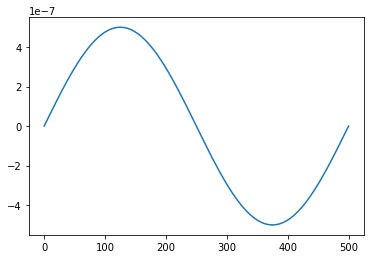

In [15]:
t = onp.linspace(0,500,501)
planet_signal = 0.5e-6*onp.sin(2*jnp.pi*(1/500)*t)

plt.plot(planet_signal)

In [14]:
%%time
osys = generate_opsys(jnp.zeros((20)))

CPU times: user 1.34 s, sys: 263 ms, total: 1.6 s
Wall time: 987 ms


Sum of image: 0.9999999999999999
Max of image: 0.0001263014112985063
CPU times: user 20.6 s, sys: 1.87 s, total: 22.5 s
Wall time: 9.93 s


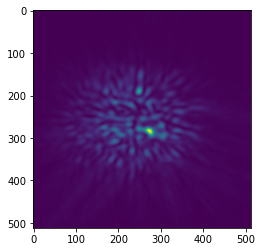

In [16]:
%%time
osys = generate_opsys(1e-7*jnp.ones(20))
image = get_double_bb_psf(6,90,osys, wavels = wavs,weights1 =  weights_A, weights2 = weights_B)
print('Sum of image: ' + str(jnp.sum(image)))
print('Max of image: ' + str(jnp.max(image)))
plt.imshow(image)

CPU times: user 5.96 s, sys: 640 ms, total: 6.6 s
Wall time: 897 ms


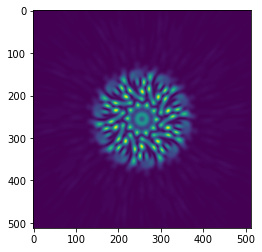

In [75]:
%%time
image = get_bb_psf(0,0,osys, wavs, weights_A)
plt.imshow(image)

CPU times: user 11min 5s, sys: 23.7 s, total: 11min 29s
Wall time: 1min 7s


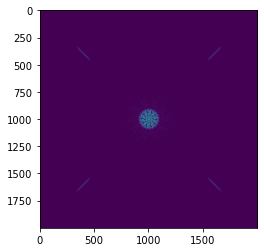

In [38]:
%%time
pscale = 0.2
osys = generate_opsys(jnp.zeros((20)))
image = get_bb_psf(0,0,osys, wavs, weights_A)
plt.imshow(image)

In [34]:
print(0.156/0.1559999 - 1)
nn = onp.load('Pscale50wavs/0.15599997.npy')
print(onp.shape(nn))

6.410260520173239e-07
(2000, 2000)


In [16]:
pscales = onp.linspace(0.155999, 0.156001,21)
new_pscales = onp.linspace(0.1559997, 0.1560003, 7)+0.00000005
newest_pscales = [0.15600003, 0.15600001,  0.15599997, 0.15599999]
print(new_pscales)

for p in tqdm(newest_pscales):
    print('{:.8f}'.format(p))
    pscale = p
    osys = generate_opsys(jnp.zeros((20)))
    image = get_bb_psf(0,0,osys, wavs, weights_A)
    onp.save('Pscale50wavs/{:.8f}'.format(p), image)

[0.15599975 0.15599985 0.15599995 0.15600005 0.15600015 0.15600025
 0.15600035]


  0%|          | 0/4 [00:00<?, ?it/s]

0.15600003


KeyboardInterrupt: 

In [37]:
pscales = onp.linspace(0.155999, 0.156001,21)
new_pscales = onp.linspace(0.1559997, 0.1560003, 7)+0.00000005
newest_pscales = [0.15600003, 0.15600001,  0.15599997, 0.15599999]

all_pscales = onp.sort(onp.append(pscales, new_pscales))
all_pscales = onp.sort(onp.append(all_pscales, newest_pscales))

correct_im = onp.load('Pscale50wavs/0.15600000.npy')

min_pscales = []
min30_pscales = []
hour_pscales = []

fluxes = [1.8e9*60, 1.8e9*60*30, 1.8e9*60*60]
for j in range(3):
    flux = fluxes[j]
    print('\n Flux: {:.2e}'.format(fluxes[j]))
    correct = 0
    within1 = 0
    within2 = 0
    for i in tqdm(range(100)):
        noisy_im = make_noisy(correct_im, flux)

        lowest = 100
        low_p = 100
        for p in all_pscales:
            comp_im = onp.load('Pscale50wavs/{:.8f}.npy'.format(p))
            sae = onp.sum(onp.abs(noisy_im - comp_im))
            if sae < lowest:
                lowest = sae
                low_p = p 
        if j ==0:
            min_pscales = onp.append(min_pscales, low_p)
        if j ==1:
            min30_pscales = onp.append(min30_pscales, low_p)    
        if j ==2:
            hour_pscales = onp.append(hour_pscales, low_p)
            
        if low_p >= 0.1559998 and low_p <= 0.1560002:
            within2 +=1
            if low_p >= 0.1559999 and low_p <= 0.1560001:
                within1 +=1
                if low_p == 0.156:
                    correct +=1

    print(correct)
    print(within1)
    print(within2)


 Flux: 1.08e+11


  0%|          | 0/100 [00:00<?, ?it/s]

4
96
100

 Flux: 3.24e+12


  0%|          | 0/100 [00:00<?, ?it/s]

1
100
100

 Flux: 6.48e+12


  0%|          | 0/100 [00:00<?, ?it/s]

1
100
100



 Minute
Mean: 2.9700000014898364e-08
STD: 5.532549141536283e-08

 30 Minute
Mean: -3.509999998985158e-08
STD: 1.1789402018625364e-08

 Hour
Mean: -3.769999998293194e-08
STD: 1.1563304022912283e-08
32
[0.155999   0.1559991  0.1559992  0.1559993  0.1559994  0.1559995
 0.1559996  0.1559997  0.15599975 0.1559998  0.15599985 0.1559999
 0.15599995 0.15599997 0.15599999 0.156      0.15600001 0.15600003
 0.15600005 0.1560001  0.15600015 0.1560002  0.15600025 0.1560003
 0.15600035 0.1560004  0.1560005  0.1560006  0.1560007  0.1560008
 0.1560009  0.156001  ]
1.9038461551712516e-07
2.9700000014898364e-08


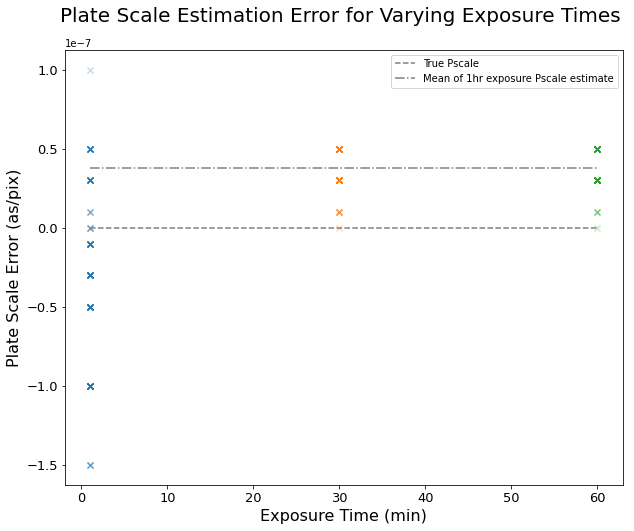

In [39]:
ones = onp.ones(100)
plt.figure(figsize = (10,8))
plt.scatter(ones, min_pscales - 0.156, marker = 'x', alpha = 0.25)
plt.scatter(ones*30, min30_pscales - 0.156, marker = 'x', alpha =  0.25)
plt.scatter(ones*60, hour_pscales - 0.156, marker = 'x', alpha = 0.25)
plt.hlines(0, 1,60, ls = '--', color = 'grey', label = 'True Pscale')
plt.hlines(onp.mean(hour_pscales)-0.156, 1,60, ls = '-.', color = 'grey', label = 'Mean of 1hr exposure Pscale estimate')
plt.legend()

plt.xlabel('Exposure Time (min)', fontsize = 16)
plt.ylabel('Plate Scale Error (as/pix)', fontsize = 16)
plt.title('Plate Scale Estimation Error for Varying Exposure Times \n', fontsize = 20)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

print('\n Minute')
print('Mean: {}'.format(0.156 - onp.mean(min_pscales)))
print('STD: {}'.format(onp.std(min_pscales)))

print('\n 30 Minute')
print('Mean: {}'.format(0.156 - onp.mean(min30_pscales)))
print('STD: {}'.format(onp.std(min30_pscales)))

print('\n Hour')
print('Mean: {}'.format(0.156 - onp.mean(hour_pscales)))
print('STD: {}'.format(onp.std(hour_pscales)))



print(len(all_pscales))
print(all_pscales)

print(-onp.mean(min_pscales)/0.156 + 1)
print(-onp.mean(min_pscales) + 0.156)

In [158]:
true_sig = 1

amp1 = true_sig*2/(0.156) 
amp2 = true_sig*2/(0.1560000368)
amp3 = true_sig*2/(0.156+1.0665833297256921e-08)
amp4 = true_sig*2/(0.15599995469999997)
amp5 = true_sig*2/(0.156+7.003506264943969e-08)

print(amp1)
print(amp2)
print(amp4)
print((1-amp2/amp1)*100) # will underestimate the uncertainty by 2.34e-5 % if overetimation of plate scale is not corrected
print((1-amp3/amp1)*100) # the std of error from uncertainty in the pscale is 6.84e-6 % ??
print((1-amp4/amp1)*100) # will underestimate the uncertainty by 2.34e-5 % if overetimation of plate scale is not corrected
print((1-amp5/amp1)*100) # the std of error from uncertainty in the pscale is 6.84e-6 % ??

12.820512820512821
12.820509796187434
12.82051654339359
2.3589738018525708e-05
6.837072175081005e-06
-2.9038469984143944e-05
4.4894250772475885e-05


In [20]:
def create_images(magnitude, path):
    '''
    magnitude is in nm
    Applies uniform amount of each zernike mode to the image
    '''
    zernikes = onp.zeros(20)
    for i in range(20):
        zernikes[i] = magnitude*1e-9 / norm_factors[i]

    zernike_coefficients = zernikes
    optical_system = generate_opsys(zernikes)
    print('Creating 101 images with {}nm of aberration.'.format(magnitude))

    for j in tqdm(range(101)):
        image = get_double_bb_psf(6+planet_signal[j] ,90, optical_system, wavels = wavs,weights1 =  weights_A, weights2 = weights_B)

        image_HDU = fits.ImageHDU(image)
        hdr = fits.Header()

        hdr['Signal']  = onp.float64(planet_signal[j])
        hdr['JitterX'] = 0
        hdr['JitterY'] = 0
        hdr['Roll']    = 0
        for k in range(20):
            hdr['zern_{}'.format(k)] = zernike_coefficients[k]

        head = fits.PrimaryHDU(header = hdr)
        hdu = fits.HDUList([head, image_HDU])

        name = 'Epoch{}.fits'.format(j)

        hdu.writeto(path+name)
        

In [19]:
def calculate_fit(overshot, image_path, save_path, magnitude):
    flux = 1.8e9 * 60 * 60
    
    for k in tqdm(range(len(overshot))):
        print('Fitting overshot: ' + str(overshot[k]))
        recovered_signal = []
        for i in tqdm(range(100)):
            full_path = image_path + 'Epoch{}.fits'.format(i)
            data = fits.open(full_path)
            image = data[1].data
            hdr = data[0].header

            ls = []
            for j in range(20):
                ls = onp.append(ls, hdr['zern_{}'.format(j)]*(overshot[k]))
            x0 = hdr['signal']
            input_image = make_noisy2(image, flux)
            fit =  scipy.optimize.minimize(objective2, x0,method='bfgs', args=(input_image, ls), jac = gradient2, options={'gtol': 1e-08})
            seperation_estimate = fit.x[0]

            recovered_signal = onp.append(recovered_signal, seperation_estimate)

        name = '{}nm-overshot{}'.format(magnitude, str(overshot[k]))
        onp.save(save_path+name, recovered_signal)

In [ ]:
%%time

overshot = onp.array([0, 0.75, 0.9, 0.95, 1, 1.05, 1.1, 1.25, 2])
                     
print(overshot)
calculate_fit(overshot,'Final fitting/500/100nm/', 'Final fitting/500/Results/', 100)


[0.   0.75 0.9  0.95 1.   1.05 1.1  1.25 2.  ]


  0%|          | 0/9 [00:00<?, ?it/s]

Fitting overshot: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting overshot: 0.75


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting overshot: 0.9


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting overshot: 0.95


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting overshot: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Fitting overshot: 1.05


  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
%%time

#create_images(1, 'Final fitting/500/1nm/')
#create_images(2, 'Final fitting/500/2nm/')
#create_images(0, 'Final fitting/500/0nm/')
#create_images(5, 'Final fitting/500/5nm/')
create_images(100, 'Final fitting/500/100nm/')

Creating 101 images with 100nm of aberration.


  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 20min 42s, sys: 2min 28s, total: 23min 10s
Wall time: 3min 20s


In [34]:
overshot = [0]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/0nm/', 'Final fitting/500/Results/', 0)
#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)

print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 0


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [35]:
overshot = [0.75]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 0.75


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [36]:
overshot = [0.9]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 0.9


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [37]:
overshot = [0.95]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 0.95


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [38]:
overshot = [1]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 1


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [39]:
overshot = [1.05]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 1.05


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [40]:
overshot = [1.1]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 1.1


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [41]:
overshot = [1.25]#, 0.5, 0.75. 0.9, 0.95, 0.99, 1, 1.01, 1.05, 1.1, 1.25, 1.5]

#calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
#calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/500/Results/', 2)
#calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)
print('Done!')


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 1.25


  0%|          | 0/250 [00:00<?, ?it/s]

Done!


In [42]:
overshot = [2]
calculate_fit(overshot,'Final fitting/500/1nm/', 'Final fitting/500/Results/', 1)
calculate_fit(overshot,'Final fitting/500/5nm/', 'Final fitting/500/Results/', 5)
calculate_fit(overshot,'Final fitting/500/10nm/', 'Final fitting/500/Results/', 10)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting overshot: 2


  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# when plotting adjust the CRLB for each aberration
# test on varying zerns - see if that does anything

5.886081632563302e-06 1.2613190845159736
5.895065082443522e-06 1.1905888987600004
5.921618455283948e-06 1.2962549717384717


Text(0.5, 1.0, 'Relative accuracy based on knowledge of the optical system \n 1 hour exposure')

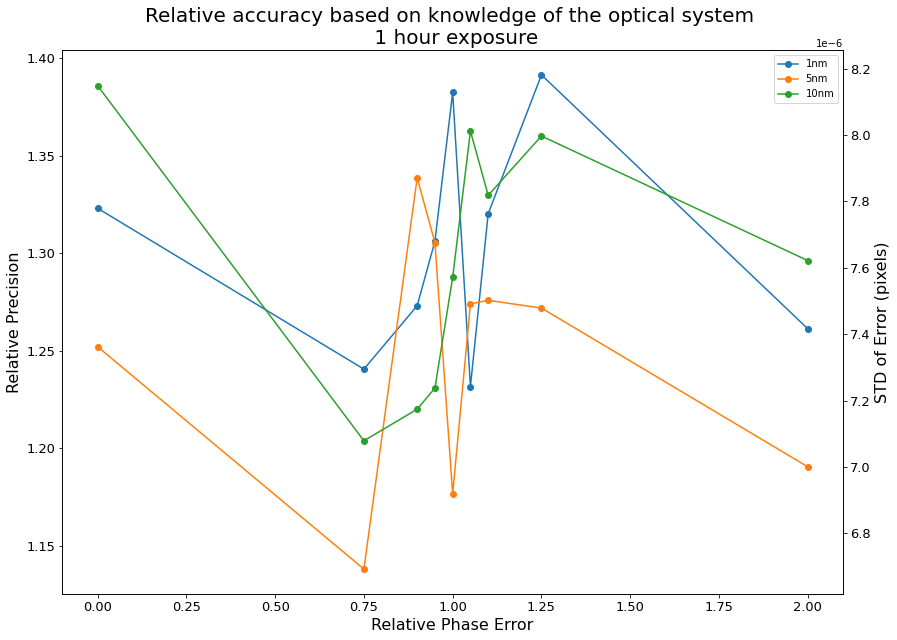

In [17]:
pscale = 0.156
overshot = [0, 0.75, 0.9, 0.95, 1, 1.05, 1.1, 1.25, 2]
phase = [0,0.75, 0.9, 0.95, 1, 1.05, 1.1, 1.25, 2]
#overshot = [0,1,2]
nm = [1,5,10]
flux = 1.8e9 * 60 *60

#plt.figure(figsize = (14,10))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_figheight(10)
fig.set_figwidth(14)
for i in nm:
    stds = onp.array([])
    for j in overshot:
        std = onp.std(onp.load('Final fitting/500/Results/{}nm-overshot{}.npy'.format(i, j)))
        std *= 2/pscale
        std /= 5.88e-6
        stds = onp.append(stds, std)
    data = fits.open('Final fitting/500/{}nm/Epoch0.fits'.format(i))
    image = data[1].data
    rao = get_cramer(image,flux)
    print(rao, std)
    ax1.plot(phase, stds, '-o', label = '{}nm'.format(i))
    ax2.plot(phase, stds*5.88e-6, alpha = 0)
    ax2.tick_params(axis = 'both', labelsize = 13)
    ax2.ticklabel_format(axis = 'y',style = 'sci', scilimits = (0,0))
#ax1.hlines(1.19,-100,100, color = 'grey', label = 'Performance with no optical aberrations')
ax1.legend()
ax1.set_xlabel('Relative Phase Error', fontsize = 16)
ax1.tick_params(axis = 'both', labelsize = 13)
ax1.set_ylabel('Relative Precision', fontsize = 16)
ax2.set_ylabel('STD of Error (pixels)', fontsize = 16) 
ax1.set_title('Relative accuracy based on knowledge of the optical system \n 1 hour exposure', fontsize = 20)
   # plt.hlines(rao, 0, 1.25)

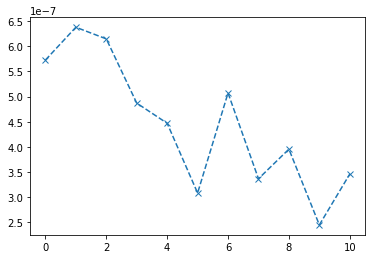

In [63]:
overshot = onp.linspace(0.9,1.1,11)
stds = onp.array([])
for i in overshot:
    std = onp.std(onp.load('Final fitting/500/10fits/1nm-overshot{:.2f}.npy'.format(i)))
    stds = onp.append(stds, std)
    
plt.plot(stds, '--x')

In [28]:
zero = onp.std(onp.load('Final fitting/500/Results/0nm-overshot0.npy'))
zero *= 2/pscale
zero /= 5.88e-6
print(zero)

1.192714022186177


In [31]:
%%time

create_images(2, 'Final fitting/2nm/')
create_images(1, 'Final fitting/1nm/')
create_images(0.5, 'Final fitting/0.5nm/')

Creating 101 images with 2nm of aberration.


  0%|          | 0/101 [00:00<?, ?it/s]

Creating 101 images with 1nm of aberration.


  0%|          | 0/101 [00:00<?, ?it/s]

Creating 101 images with 0.5nm of aberration.


  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 1h 1min 27s, sys: 7min 28s, total: 1h 8min 55s
Wall time: 9min 54s


In [ ]:
overshot = [1, 1.01, 1.05, 1.1, 1.25, 1.5]

calculate_fit(overshot,'Final fitting/0.5nm/', 'Final fitting/Results/Again/', 0.5)
calculate_fit(overshot,'Final fitting/1nm/', 'Final fitting/Results/Again/', 1)
calculate_fit(overshot,'Final fitting/2nm/', 'Final fitting/Results/Again/', 2)

  0%|          | 0/6 [00:00<?, ?it/s]

Fitting overshot: 1


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.01


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.05


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.1


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.25


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Fitting overshot: 1


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.01


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.05


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.1


  0%|          | 0/50 [00:00<?, ?it/s]

Fitting overshot: 1.25


  0%|          | 0/50 [00:00<?, ?it/s]

[8.74358218e-06 7.97687466e-06 8.60250723e-06 8.61652853e-06
 8.04119112e-06]
[0.00014816 0.00014836 0.0001478  0.00014718 0.00014769 0.00014843
 0.00014782 0.00014835 0.00014757 0.000148   0.00014793 0.00014841
 0.00014765 0.0001485  0.00014708 0.00014852 0.00014787 0.00014949
 0.00014807 0.00014882 0.00014902 0.0001486  0.00014871 0.00014926
 0.00014818 0.00014877 0.00014893 0.00014816 0.00014975 0.0001481
 0.00014908 0.00014829 0.00014841 0.00014892 0.00014806 0.00014906
 0.00014758 0.00014833 0.00014688 0.00014882 0.00014815 0.00014801
 0.00014865 0.00014841 0.00014842 0.00014867 0.00014833 0.00014761
 0.00014838 0.00014859]


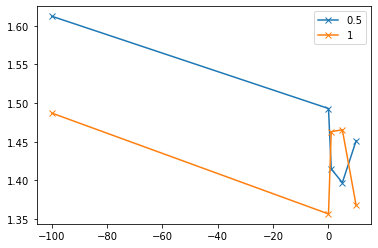

In [197]:
pscale = 0.156
mags = ['0.5', '1']#, '2']
diff = ['0','1','1.01','1.05','1.1']#,'0.5','0.75','1', '1.01','1.025', '1.05','1.075', '1.1','1.125', '1.15','1.175', '1.25','2','2.5','3']
percent = [-100,0,1,5,10]#,-50,-25,0,1,2.5,5,7.5,10,12.5,15,17.5,25,100,150,200]
rao = 5.88e-6

for i in mags:
    stds = onp.array([])
    for j in diff:
        data = []
        data4 = onp.load('Final fitting/Results/{}nm-overshot{}.npy'.format(i,j))
        #print(onp.std(data1))
        data3 = onp.load('Final fitting/Results/Again/{}nm-overshot{}.npy'.format(i,j))
        #print(onp.std(data1))
        data5 = onp.append(data3, data4)
        #data = onp.append(data1,data2)
        std = onp.std(data5 - planet_signal[:100])
        stds = onp.append(stds, std)
    stds *= 2/pscale
    plt.plot(percent, stds/rao, label = i, marker = 'x')
    
print(stds)
plt.legend()
#plt.xscale('log')
print(data2)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  SIGNAL  = 2.93892626146236E-07                                                  JITTERX =                    0                                                  JITTERY =                    0                                                  ROLL    =                    0                                                  ZERN_0  =                2E-09                                                  ZERN_1  = 5.01964636542239E-10                                                  ZERN_2  = 5.01964636542239E-10                                                  ZERN_3  = 5.77387859401098E-10                                                  ZERN_4  = 4.08998556848912E-10          

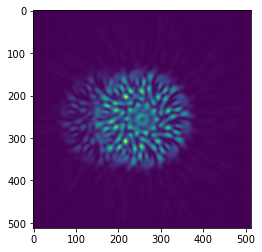

In [22]:
data = fits.open('Final fitting/2nm/Epoch10.fits')
hdr = data[0].header
print(hdr)
image = data[1].data
plt.imshow(image)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  SIGNAL  = 2.93892626146236E-07                                                  JITTERX =                    0                                                  JITTERY =                    0                                                  ROLL    =                    0                                                  ZERN_0  =                5E-10                                                  ZERN_1  = 1.25491159135559E-10                                                  ZERN_2  = 1.25491159135559E-10                                                  ZERN_3  = 1.44346964850274E-10                                                  ZERN_4  = 1.02249639212228E-10          

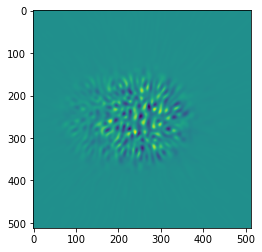

In [25]:
data = fits.open('Final fitting/0.5nm/Epoch10.fits')
hdr = data[0].header
print(hdr)
image2 = data[1].data
plt.imshow(image2 - image)

Coma X
253.7565888377452 208.04056377425408
CPU times: user 7.96 s, sys: 748 ms, total: 8.71 s
Wall time: 2.38 s


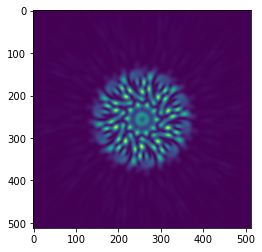

In [88]:
%%time

print(morphine.zernike.zern_name(7+1))

osys = generate_opsys(1e-9*jnp.ones(20))
image = get_bb_psf(0,0,osys, wavs, weights_A)
image = onp.array(image)
x,y = get_really_stable_anchors(image)
print(x[8,0],y[8,0])
plt.imshow(image)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

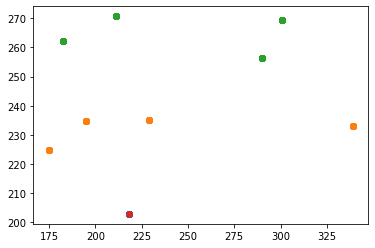

In [92]:
x_array1 = onp.array([])
y_array1 = onp.array([])

x_array1_b = onp.array([])
y_array1_b = onp.array([])

x_array1_c = onp.array([])
y_array1_c = onp.array([])

abb = onp.linspace(0,0.5,250)
abb *= 1e-9

for i in tqdm(range(250)):
    coef = onp.zeros(20)
    coef[8] = abb[i]
    osys = generate_opsys(coef)
    
    image = get_bb_psf(0,0,osys, wavs, weights_A)
    image = onp.array(image)
    
    x,y = get_really_stable_anchors(image, flux = 1.8e9*60*1)
    
    k = 8
    x_array1 = onp.append(x_array1, x[k,1])
    y_array1 = onp.append(y_array1, y[k,1])
    
    k = 18
    x_array1_b = onp.append(x_array1_b, x[k,1])
    y_array1_b = onp.append(y_array1_b, y[k,1])
    
    k = 28
    x_array1_c = onp.append(x_array1_c, x[k,1])
    y_array1_c = onp.append(y_array1_c, y[k,1])

plt.scatter(x_array1_a, y_array1_a)
plt.scatter(x_array1_b, y_array1_b)
plt.scatter(x_array1_c, y_array1_c)




x_array2 = onp.array([])
y_array2 = onp.array([])

x_array2_b = onp.array([])
y_array2_b = onp.array([])

x_array2_c = onp.array([])
y_array2_c = onp.array([])
abb = onp.array([3.75e-10])
for i in tqdm(range(1)):
    coef = onp.zeros(20)
    coef[8] = abb[i]
    osys = generate_opsys(coef)
    
    image = get_bb_psf(0,0,osys, wavs, weights_A)
    image = onp.array(image)
    
    x,y = get_really_stable_anchors(image)
    
    k = 8
    x_array2 = onp.append(x_array2, x[k,1])
    y_array2 = onp.append(y_array2, y[k,1])


plt.scatter(x_array2, y_array2)


In [25]:
x_array = onp.zeros((50,100))
y_array = onp.zeros((50,100))
abb = onp.linspace(0,0.5,100)
abb *= 1e-9

for i in tqdm(range(100)):
    coef = onp.zeros(20)
    coef[8] = abb[i]
    osys = generate_opsys(coef)
    
    image = get_bb_psf(0,0,osys, wavs, weights_A)
    image = onp.array(image)
    
    x,y = get_really_stable_anchors(image)
    
    for k in range(50):
        x_array[k, i] = x[k,1]
        y_array[k, i] = y[k,1]



  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
print(len(x_array[1,:]))

100


In [20]:
from sklearn.linear_model import LinearRegression

In [54]:
abb = onp.linspace(0,0.5,100)
abb *= 1e-9

x1 = x_array1
y1 = abb.reshape(1,-1)[0]

x_model = LinearRegression()
x_model.fit(x1.reshape(-1,1),y1)

x2 = y_array1
y2 = abb.reshape(1,-1)[0]

y_model = LinearRegression()
y_model.fit(x2.reshape(-1,1),y2)

x_new = x_array2
y_new = y_array2
abb_pred1 = x_model.predict(x_new.reshape(-1, 1))
abb_pred2 = y_model.predict(y_new.reshape(-1, 1))

best_estimate = abb_pred1/2 + abb_pred2/2
print(best_estimate)



[1.96337983e-10]


In [73]:
def get_anchs(magnitude):
    coef = onp.zeros(20)
    coef[8] = magnitude
    osys = generate_opsys(coef)
    
    image = get_bb_psf(0,0,osys, wavs, weights_A)
    image = onp.array(image)
    
    x,y = get_really_stable_anchors(image)
    
    k = 8
    return x[k,1], y[k,1]

def best_estimate(x,y):
    x1 = x_array1
    y1 = abb.reshape(1,-1)[0]

    x_model = LinearRegression()
    x_model.fit(x1.reshape(-1,1),y1)

    x2 = y_array1
    y2 = abb.reshape(1,-1)[0]

    y_model = LinearRegression()
    y_model.fit(x2.reshape(-1,1),y2)

    x_new = x
    y_new = y
    abb_pred1 = x_model.predict(x_new.reshape(-1, 1))
    abb_pred2 = y_model.predict(y_new.reshape(-1, 1))

    best_estimate = abb_pred1/2 + abb_pred2/2
    return best_estimate

def best_estimate2(x,y):
    the_estimate = 0
    for i in range(1):
        i = 8
        x1 = x_array[i,:]
        y1 = abb.reshape(1,-1)[0]

        x_model = LinearRegression()
        x_model.fit(x1.reshape(-1,1),y1)

        x2 = y_array[i,:]
        y2 = abb.reshape(1,-1)[0]

        y_model = LinearRegression()
        y_model.fit(x2.reshape(-1,1),y2)

        x_new = x
        y_new = y
        abb_pred1 = x_model.predict(x_new.reshape(-1, 1))
        abb_pred2 = y_model.predict(y_new.reshape(-1, 1))

        best_estimate = abb_pred1/2 + abb_pred2/2
        print(best_estimate)
        the_estimate += best_estimate/1
    print(the_estimate)
    return the_estimate
    

In [93]:
abb = onp.linspace(0,0.5,250)
abb *= 1e-9


abs_error_arr = onp.array([])
percent_error_arr = onp.array([])
for i in tqdm(range(250)):
    rand = onp.random.rand()
    mag = 0.5e-9 * rand
    x,y = get_anchs(mag)
    est = best_estimate(x,y)
    
    abs_error = onp.abs(est - mag)
    percent_error = est/mag - 1
    
    
    abs_error_arr = onp.append(abs_error_arr, abs_error)
    percent_error_arr = onp.append(percent_error_arr, percent_error)
    
    
    

  0%|          | 0/250 [00:00<?, ?it/s]

In [94]:
print('\n Absolute Error: ')
print('Mean: {:.2e}'.format(onp.mean(abs_error_arr)))
print('STD:  {:.2e}'.format(onp.std(abs_error_arr)))

print('\n Percent Error: ')
print('Mean: {:.2e}'.format(onp.mean(percent_error_arr)))
print('STD:  {:.2e}'.format(onp.std(percent_error_arr)))

# 1 min


 Absolute Error: 
Mean: 1.39e-10
STD:  7.93e-11

 Percent Error: 
Mean: 3.72e+00
STD:  2.92e+01


In [ ]:
# I could in theory use this to estimate the zernike mode.
# check if this is the same for all zern modes

0.06621999809126727


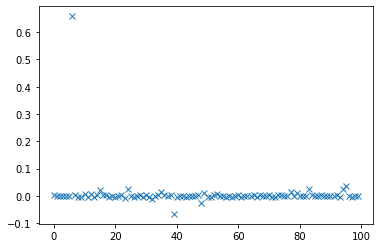

In [316]:
plt.plot(percent_error_arr, 'x')
new_arr = percent_error_arr
new_arr = new_arr[onp.abs(new_arr) <3e3]
print(onp.std(new_arr))
